In [ ]:
# Import required python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

import warnings
warnings.filterwarnings('ignore')

#### Building and post-processing a MODFLOW 6 model: Well drawdown example
A MODFLOW 6 model will be developed of the domain shown below. This model simulation is adapted from example 1 in Pollock, D.W., 2016, User guide for MODPATH Version 7—A particle-tracking model for MODFLOW: U.S. Geological Survey Open-File Report 2016–1086, 35 p., http://dx.doi.org/10.3133/ofr20161086.

The model domain will be discretized into 6 layers, 41 rows, and 40 columns. Each grid cell is 250 x 250 m in the horizontal plane. The model has one steady-state stress period. The average annual recharge rate due to precipitation is 1x10$^{-7}$ m/s. The locations of the river, aquifers, and confining unit are shown in the diagram below. A well is located within the center of the model domain.

All documentation for the FloPy package can be found at: https://flopy.readthedocs.io/en/3.6.0/index.html

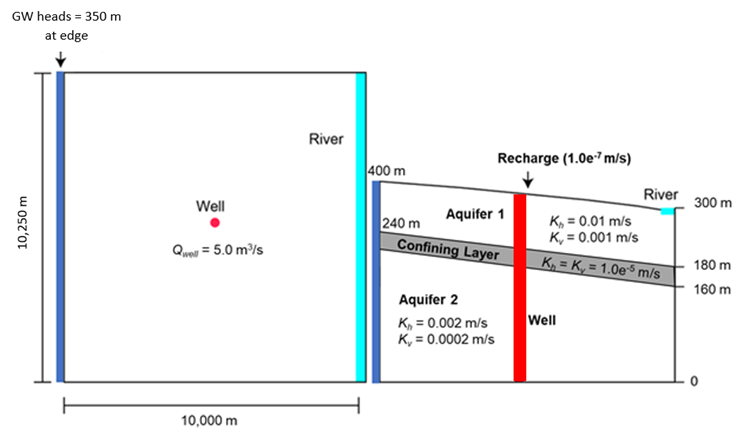

In [ ]:
# For running code in Binder
ws = 'Outputs' # path where output files will be saved
name = 'Ex2_well' # name that will be assigned to output files
exe_name = 'mf6.exe' # path where executables are saved

In [ ]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, sim_ws=ws)

# create tdis package
tdis = flopy.mf6.ModflowTdis(sim, time_units='seconds') # can specify time units and time steps here

# create iterative model solution
ims = flopy.mf6.ModflowIms(sim)

##### Create the gwf model object using flopy.mf6.ModflowGwf().

In [ ]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

##### Create the discretization package using flopy.mf6.ModflowGwfdis().

In [ ]:
nlay, nrow, ncol = 6, 41, 40
delr = delc = 250. # width of grid cells
top = np.ones((nrow,ncol))*np.linspace(400,300,ncol) # surface topography array

botm = [np.ones((nrow,ncol))*np.linspace(320,240,ncol), 
        np.ones((nrow,ncol))*np.linspace(240,180,ncol),
        np.ones((nrow,ncol))*np.linspace(220,160,ncol), 
        np.ones((nrow,ncol))*np.linspace(150,110,ncol),
        np.ones((nrow,ncol))*np.linspace(75,50,ncol),
        0] # elevations of each layer

In [ ]:
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,
                              length_units="METERS") # specify length units

##### Visualize (plot) the model grid to confirm that the discretization is correctly defined.

In [ ]:
# Planar view of model grid
mm = flopy.plot.PlotMapView(model=gwf)
mm.plot_grid()
plt.show()

In [ ]:
# Cross sectional view of model grid
xs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 20})
xs.plot_grid()
plt.show()

##### Create the initial conditions (IC) package
Create the discretization package using flopy.mf6.ModflowGwfic() and set the initial head (strt) to 380 m. Default values can be used for the rest of the initial conditions package input.

In [ ]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=380.)

##### Create the node property flow (NPF) package
The hydraulic properties for the model are defined in the image above. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so icelltype should be [1, 0, 0]. The variable save_specific_discharge should be set to True so that specific discharge data are saved to the cell-by-cell file and can be used to plot discharge.

In [ ]:
# Define aquifer properties
kh = [0.01, 0.01, 1e-5, 0.002, 0.002, 0.002] # horizontal K of each layer
kv = [0.001, 0.001, 1e-5, 0.0002, 0.00002, 0.002] # vertical K of each layer
icelltype = [1, 1, 0, 0, 0, 0, ] # layers: unconfined, confined, confined

npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=icelltype, k=kh, k33=kv)

##### Create the recharge package
The recharge rate is 1x10$^{-7}$ m/s. Use the flopy.mf6.ModflowGwfrcha() method to specify recharge data using arrays.

In [ ]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=1e-7)

##### Create the well package
The well is located in layer 6 (screened in the bottom 60 m of the confined aquifer), row 21, column 20. The pumping rate is 5 m$^3$/s. In MODFLOW pumping groundwater out of a well is displayed as a negative value, while injecting water into a well is a positive value. Therefore we will use a negative value when specifying the pumping rate in the FloPy well package.

In [ ]:
wel_spd = {0: [[(5, 20, 19), -5]]} # stress period: [[cell coordinates (lay, row, col), pumping rate]]
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, stress_period_data=wel_spd)

##### Create the river package
The river is located in layer 1 and column 40 in every row in the model. The river stage stage and bottom are at 300 and 298 m, respectively; the river bed conductance is 1x10$^{4}$ m/s.

In [ ]:
riv_spd = {0: [[(0, i, 39), 300, 1e4, 298] for i in range(nrow)]} # time step, cell coordinates, river stage, bed conductance, river bed elevation
#riv_spd

In [ ]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

##### Create the general head package
The heads 1 m from the western boundary (the first column) are 350 m.

In [ ]:
# Format concatonated general head data into recarray            
g_cond_l1 = (0.01*delr*30)/1.0 # Kh * width of cell* saturated cell vertical thickness
g_cond_l2 = (0.01*delr*60)/1.0
g_cond_l3 = (1e-5*delr*20)/1.0
g_cond_l4 = (0.002*delr*70)/1.0
g_cond_l5 = (0.002*delr*75)/1.0
g_cond_l6 = (0.002*delr*75)/1.0

ghd = []
for i in range(nrow):
    ghd_info_l1 = [(0, i, 0), 350, g_cond_l1] # grid cells (layer, row, column), head, conductance
    ghd.append(ghd_info_l1)
    ghd_info_l2 = [(1, i, 0), 350, g_cond_l2] # grid cells (layer, row, column), head, conductance
    ghd.append(ghd_info_l2)
    ghd_info_l3 = [(2, i, 0), 350, g_cond_l3] # grid cells (layer, row, column), head, conductance
    ghd.append(ghd_info_l3)
    ghd_info_l4 = [(3, i, 0), 350, g_cond_l4] # grid cells (layer, row, column), head, conductance
    ghd.append(ghd_info_l4)
    ghd_info_l5 = [(4, i, 0), 350, g_cond_l5] # grid cells (layer, row, column), head, conductance
    ghd.append(ghd_info_l5)
    ghd_info_l6 = [(5, i, 0), 350, g_cond_l6] # grid cells (layer, row, column), head, conductance
    ghd.append(ghd_info_l6)
#ghd

In [ ]:
# Edges as general head boundary
ghdPackage = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghd)

##### Build output control
Define the output control for the model using the flopy.mf6.ModflowGwfoc method to [('HEAD', 'ALL'), ('BUDGET', 'ALL')] to save the head and flow for the model. Because we haven't set SAVE_FLOWS to True in all of the packages we can set .name_file.save_flows to True for the groundwater flow model (gwf) to save flows for all packages that can save flows. Also the head (head_filerecord) and cell-by-cell flow (budget_filerecord) files should be set to name+'.hds' and name+'.cbc', respectively.

In [ ]:
hname = '{}.hds'.format(name)
cname = '{}.cbc'.format(name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                            head_filerecord=hname,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [ ]:
gwf.name_file.save_flows = True

##### Write the model files and run the model

In [ ]:
sim.write_simulation()
sim.run_simulation()

##### Post-process the results
Load the heads and face flows from the hds and cbc files. The head file can be loaded with the flopy.utils.HeadFile() method. The cell-by-cell file can be loaded with the flopy.utils.CellBudgetFile() method. MODFLOW 6 creates double precision binary files so precision='double' needs to be passed to the flopy.utils.CellBudgetFile() method. The flopy.utils.HeadFile() method autodetects the precision of the head file. The precision of the head file is a attribute on the head file object (hobs.precision) and could be passed as the precision parameter.

###### Retrieve the head data from the .hds file

In [ ]:
fpth = os.path.join(ws, hname)
hobj = flopy.utils.HeadFile(fpth)

In [ ]:
hds = hobj.get_data()

In [ ]:
fpth = os.path.join(ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision="double")

In [ ]:
cobj.list_unique_records()

###### Retrieve the 'DATA-SPDIS' data type from the cell-by-cell file.

In [ ]:
spd = cobj.get_data(text='SPDIS')[0]

#### Plot the results
Plot the results using flopy.plot.PlotMapView(). The head results can be plotted using the .plot_array() method. The discharge results can be plotted using the plot_specific_discharge() method. Boundary conditions can be plotted using the .plot_bc() method.

##### Map View Plots:

In [ ]:
# Plot groundwater heads in the top layer
plt.figure()
mm = flopy.plot.PlotMapView(model=gwf)
fig1 = plt.gcf()
fig1.set_figheight(5)
fig1.set_figwidth(5)
ax = plt.gca()
img = mm.plot_array(hds[0,:,:]) # the top layer is layer 0
c = mm.contour_array(hds[0,:,:], colors='black',levels=np.arange(250, 390, 5))
plt.clabel(c, fmt='%.2f')
fig1.colorbar(img, fraction=0.05, label="Groundwater Head (m asl)")
plt.show()

In [ ]:
# Plot the flow vectors
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd,gwf)

mm = flopy.plot.PlotMapView(model=gwf, layer=0) # plot data from layer 1
fig2 = plt.gcf()
fig2.set_figheight(5)
fig2.set_figwidth(5)
mm.plot_array(hds) # add heads
quiver = mm.plot_vector(qx, qy) # add flow vectors
mm.plot_bc('RIV', color='blue')
plt.show()

##### Cross Section Plots:
Plot the groundwater heads in each model cell along a cross section

In [ ]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 20})
csa = xsect.plot_array(hds) # plot the heads in cross-section view
linecollection = xsect.plot_grid()
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd,gwf) # extract the specific discharge vector components
xsect.plot_vector(qx, qy, qz) # plot specific disharge vectors
plt.title('Row 20 Cross-Section of Groundwater Heads & Flow Vectors') # graph title
fig.colorbar(csa, fraction=0.05, label="Groundwater Head (m asl)") # colorbar label
plt.show()

In [ ]:
# Plot boundary conditions along cross section to check their placement
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 20})
patches = xsect.plot_bc('RIV', color='blue')
patches = xsect.plot_bc('GHB', color='cyan')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid()
t = ax.set_title('Row 20 Cross-Section with Boundary Conditions')
plt.show()

In [ ]:
# Save calculated heads in each layer to csv files
hds_layer1 = hds[0, :, :]
hds_layer2 = hds[1, :, :]
hds_layer3 = hds[2, :, :]
hds_layer4 = hds[3, :, :]
hds_layer5 = hds[4, :, :]
hds_layer6 = hds[5, :, :]
np.savetxt('Outputs/Layer1_hds_well.csv', hds_layer1, delimiter=',')
np.savetxt('Outputs/Layer2_hds_well.csv', hds_layer2, delimiter=',')
np.savetxt('Outputs/Layer3_hds_well.csv', hds_layer3, delimiter=',')
np.savetxt('Outputs/Layer4_hds_well.csv', hds_layer4, delimiter=',')
np.savetxt('Outputs/Layer5_hds_well.csv', hds_layer5, delimiter=',')
np.savetxt('Outputs/Layer6_hds_well.csv', hds_layer6, delimiter=',')